# Distributions & group format design

For each distribution:

 - How does the maximum grow?
 - What is an optimal element dtype?

In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import tensor, Tensor
import transformers
import scipy.stats
import seaborn as sns
from functools import partial

import quantisation.quantisation as Q

matplotlib.rcParams.update({"axes.spines.top": False, "axes.spines.right": False, "legend.frameon": False})

DEFAULT_DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Model of group maximum

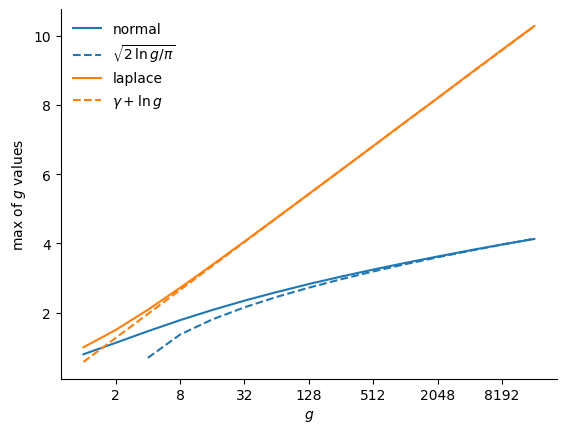

In [3]:
gs = 2**torch.arange(15)
n = 2**24

_, ax = plt.subplots()
for dist, hue in zip(["normal", "laplace"], sns.color_palette()):
    if dist == "normal":
        x = torch.randn(n)
    if dist == "laplace":
        x = torch.distributions.Laplace(0, 1).sample((n,))
    max_sim = tensor([x.abs().view(-1, g).max(-1).values.mean() for g in gs])

    ax.plot(gs, max_sim, color=hue, label=f"{dist}")
    if dist == "normal":
        ax.plot(gs, gs.div(torch.pi).log().mul(2).sqrt(), color=hue, ls="--", label=r"$\sqrt{2\, \ln g/\pi}$")
    if dist == "laplace":
        ax.plot(gs, 0.577 + gs.log(), color=hue, ls="--", label=r"$\gamma + \ln g$")

ax.legend()
ax.set_xscale("log", base=2)
ax.xaxis.set_major_formatter("{x:.0f}")
ax.set_xlabel("$g$")
ax.set_ylabel("max of $g$ values");

## Optimal element format

### Quantiser shape

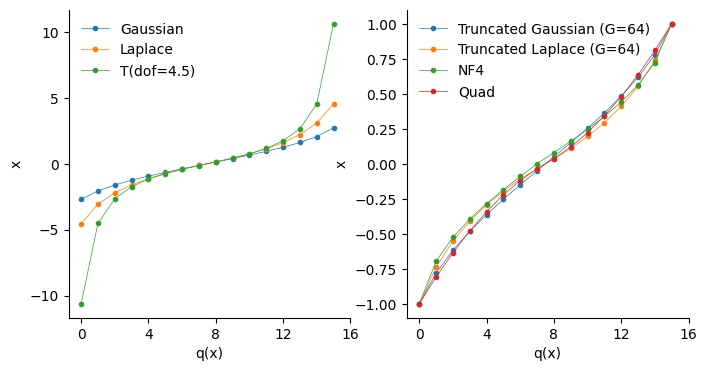

In [28]:
_, (ax0, ax1) = plt.subplots(ncols=2, figsize=(8, 4))

args = dict(marker="o", ms=3, lw=.5)
bits = 4
ax0.plot(Q.crp_gauss(bits).values, label="Gaussian", **args)
ax0.plot(Q.crp_laplace(bits).values, label="Laplace", **args)
ax0.plot(Q.crp_t(bits, 4.5).values, label="T(dof=4.5)", **args)

group_size = 64
ax1.plot(Q.crp_trunc_gauss(bits, group_size, True).values, label=f"Truncated Gaussian (G={group_size})", **args)
ax1.plot(Q.crp_trunc_laplace(bits, group_size, True).values, label=f"Truncated Laplace (G={group_size})", **args)
ax1.plot(Q.NF4.values, label="NF4", **args)
ax1.plot(Q.lut_function(lambda x: x * (1 + abs(x)) / 2, 4, "quad").values, label="Quad", **args)

for ax in [ax0, ax1]:
    ax.legend(loc="upper left")
    ax.set_xlabel("q(x)")
    ax.set_ylabel("x")
    ax.set_xticks([0, 4, 8, 12, 16])

### Compare quantisers

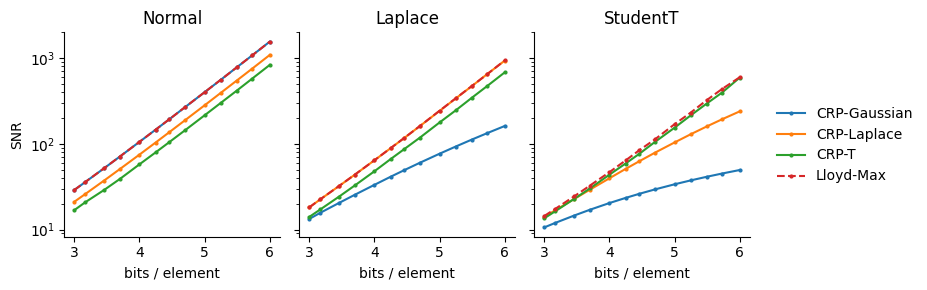

In [66]:
distributions = [
    torch.distributions.Normal(0, 1),
    torch.distributions.Laplace(0, 1),
    torch.distributions.StudentT(4.5, 0, 1),
]
methods = [
    ("CRP-Gaussian", lambda b, _: Q.crp_gauss(b)),
    ("CRP-Laplace", lambda b, _: Q.crp_laplace(b)),
    ("CRP-T", lambda b, _: Q.crp_t(b, dof=4.5)),
    ("Lloyd-Max", lambda b, x: Q.lut_lloyd_max(x, b, iterations=1000)),
]

fig, axs = plt.subplots(ncols=len(distributions), figsize=(2.5*len(distributions), 3), sharey=True)
for dist, ax in zip(distributions, axs):
    x = dist.sample((2**20,)).to(DEFAULT_DEVICE)
    x /= x.pow(2).mean().sqrt()

    for name, method in methods:
        fmts = [method(b, x) for b in torch.linspace(3, 6, 13)]
        ax.plot([fmt.count_bits(x.shape) / x.nelement() for fmt in fmts],
                [Q.snr(x, fmt.quantise(x)).item() for fmt in fmts],
                label=name, marker='o', ms=2, ls="--" if name == "Lloyd-Max" else "-")

    ax.set_title(type(dist).__name__)
    ax.set_yscale("log")
    ax.set_xlabel("bits / element")
fig.tight_layout()
fig.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5))
axs[0].set_ylabel("SNR");

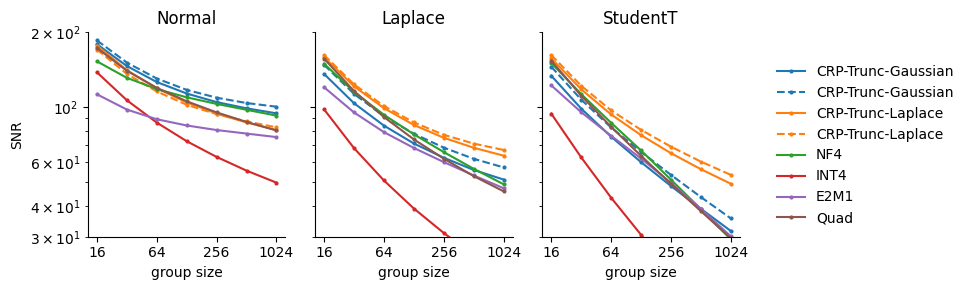

In [23]:
distributions = [
    torch.distributions.Normal(0, 1),
    torch.distributions.Laplace(0, 1),
    torch.distributions.StudentT(4.5, 0, 1),
]
methods = [
    ("CRP-Trunc-Gaussian", "absmax", lambda g: Q.crp_trunc_gauss(4, g, symmetric=True)),
    ("CRP-Trunc-Gaussian", "signmax", lambda g: Q.crp_trunc_gauss(4, g, symmetric=False)),
    ("CRP-Trunc-Laplace", "absmax", lambda g: Q.crp_trunc_laplace(4, g, symmetric=True)),
    ("CRP-Trunc-Laplace", "signmax", lambda g: Q.crp_trunc_laplace(4, g, symmetric=False)),
    ("NF4", "absmax", lambda _: Q.NF4),
    ("INT4", "absmax", lambda _: Q.parse("E0M3")),
    ("E2M1", "absmax", lambda _: Q.parse("E2M1")),
    ("Quad", "absmax", lambda _: Q.lut_function(lambda x: x * (1 + abs(x)) / 2, 4, "quad")),
]

fig, axs = plt.subplots(ncols=len(distributions), figsize=(2.5*len(distributions), 3), sharey=True)
for dist, ax in zip(distributions, axs):
    x = dist.sample((2**20,)).to(DEFAULT_DEVICE)

    colors = iter(sns.color_palette())
    name_to_color = defaultdict(lambda: next(colors))
    for name, scaling, method in methods:
        group_size = 2**torch.arange(4, 11)
        fmts = [Q.LinearScalingFormatV2(method(g.item()), Q.BFLOAT16, (g,), scaling) for g in group_size]
        ax.plot(group_size, [Q.snr(x, fmt.quantise(x)).item() for fmt in fmts],
                marker='o', ms=2,
                color=name_to_color[name], label=name, ls=dict(absmax="-", signmax="--")[scaling])

    ax.set_title(type(dist).__name__)
    ax.set_yscale("log")
    ax.set_xscale("log", base=2)
    ax.set_xlabel("group size")
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xticks(2**torch.arange(4, 11, 2))
    ax.set_ylim((30, 200))
fig.tight_layout()
fig.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5))
axs[0].set_ylabel("SNR");

### Sweep group size (fixed bits/value)

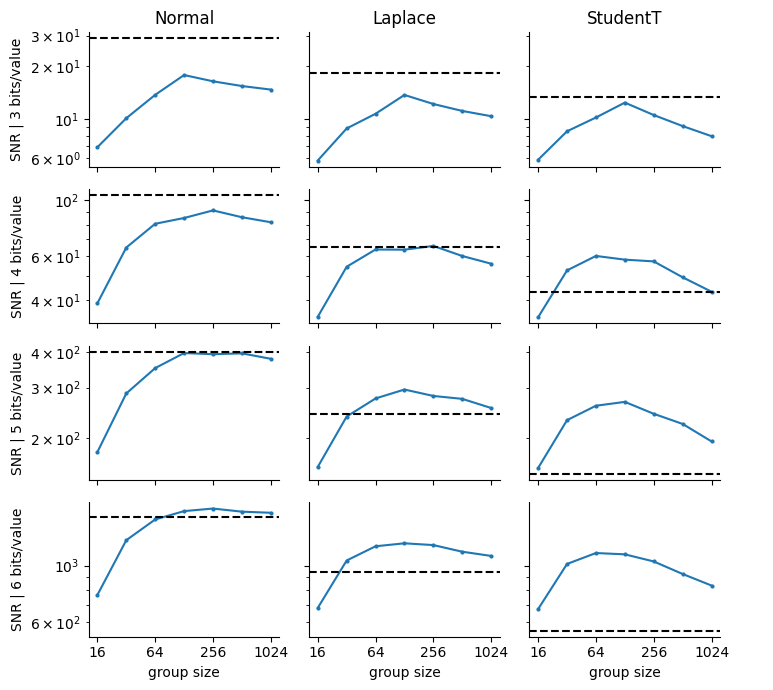

In [2]:
bits = [3, 4, 5, 6]
distributions = [
    torch.distributions.Normal(0, 1),
    torch.distributions.Laplace(0, 1),
    torch.distributions.StudentT(4.5, 0, 1),
]

fig, axs = plt.subplots(nrows=len(bits), ncols=len(distributions), figsize=(2.5*len(distributions), 1.75*len(bits)),
                        sharex=True, sharey="row")
for nbit, axr in zip(bits, axs):
    for dist, ax in zip(distributions, axr):
        x = dist.sample((2**22,)).to(DEFAULT_DEVICE)
        method = Q.crp_trunc_gauss if isinstance(dist, torch.distributions.Normal) else Q.crp_trunc_laplace

        group_size = 2**torch.arange(4, 11)
        fmts = [Q.LinearScalingFormatV2(method(nbit - 16/g.item(), g.item(), symmetric=True), Q.BFLOAT16, (g,), "absmax") for g in group_size]
        ax.plot(group_size, [Q.snr(x, fmt.quantise(x)).item() for fmt in fmts],
                marker='o', ms=2)

        ref_method = dict(Normal=Q.crp_gauss, Laplace=Q.crp_laplace, StudentT=lambda b: Q.crp_t(b, dof=dist.df.item()))[type(dist).__name__]
        ref_fmt = Q.LinearScalingFormatV2(ref_method(nbit), Q.BFLOAT16, (None,), "rms")
        ax.axhline(Q.snr(x, ref_fmt.quantise(x)).item(), color="k", ls="--")

        ax.set_yscale("log")
        ax.set_xscale("log", base=2)
        ax.xaxis.set_major_formatter("{x:.0f}")
        ax.set_xticks(2**torch.arange(4, 11, 2))
        if axr[0] is axs[0, 0]:
            ax.set_title(type(dist).__name__)
        if axr[0] is axs[-1, 0]:
            ax.set_xlabel("group size")
    axr[0].set_ylabel(f"SNR | {nbit} bits/value")
fig.tight_layout()
fig.legend(*axs[0, 0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5));

### ...with compression

In [208]:
def count_bits_compressed(fmt: Q.TensorFormat, x: Tensor) -> float:
    if isinstance(fmt, Q.ScaledFormat):
        return count_bits_compressed(fmt.format, x / fmt.scale)
    if isinstance(fmt, Q.IntFormat):
        q = fmt.quantise(x).to(torch.int32)
        counts = q.sub(fmt.range[0]).bincount(minlength=fmt.range[1] - fmt.range[0])
        return -(counts * counts.float().div(x.nelement()).log2().nan_to_num(0)).sum()
    if isinstance(fmt, Q.LUTFormat):
        table = tensor(fmt.values, dtype=x.dtype, device=x.device)
        bin_edges = (table[1:] + table[:-1]) / 2
        counts = torch.bucketize(x, bin_edges).bincount(minlength=len(fmt.values))
        return -(counts * counts.float().div(x.nelement()).log2().nan_to_num(0)).sum()
    if isinstance(fmt, Q.LinearScalingFormatV2):
        value_bits = count_bits_compressed(fmt.element_format, x / fmt.scale_for(x))
        return value_bits + (fmt.count_bits(x.shape) - fmt.element_format.count_bits(x.shape))
    raise NotImplementedError(f"Not implemented for format {type(fmt).__name__}")

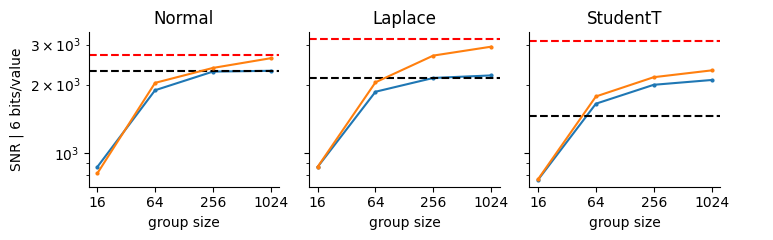

In [209]:
distributions = [
    torch.distributions.Normal(0, 1),
    torch.distributions.Laplace(0, 1),
    torch.distributions.StudentT(4.5, 0, 1),
]

fig, axs = plt.subplots(ncols=len(distributions), figsize=(2.5*len(distributions), 2.5),
                        sharex=True, sharey="row")
for dist, ax in zip(distributions, axs):
    x = dist.sample((2**22,)).to(DEFAULT_DEVICE)
    method = Q.crp_trunc_gauss if isinstance(dist, torch.distributions.Normal) else Q.crp_trunc_laplace

    nbit = 6
    nbit_tol = 0.01
    group_size = [16, 64, 256, 1024]

    # Group formats
    group_nbit = dict(  # empirical values
        Normal=[6.1, 6.15, 6.22, 6.25],
        Laplace=[6.2, 6.3, 6.42, 6.5],
        StudentT=[6.12, 6.27, 6.46, 6.65],
    )[type(dist).__name__]
    fmts = [Q.LinearScalingFormatV2(method(b - 16/g, g, symmetric=True), Q.BFLOAT16, (g,), "absmax") for g, b in zip(group_size, group_nbit)]
    for fmt in fmts:
        assert count_bits_compressed(fmt, x).item() / x.nelement() <= nbit + nbit_tol
    ax.plot(group_size, [Q.snr(x, fmt.quantise(x)).item() for fmt in fmts],
            marker='o', ms=2)

    # Tensor-scaled formats
    ref_method = dict(Normal=Q.crp_gauss, Laplace=Q.crp_laplace, StudentT=lambda b: Q.crp_t(b, dof=dist.df.item()))[type(dist).__name__]
    ref_bits = dict(Normal=6.3, Laplace=6.6, StudentT=6.7)[type(dist).__name__]  # empirical values
    ref_fmt = Q.LinearScalingFormatV2(ref_method(ref_bits), Q.BFLOAT16, (None,), "rms")
    assert count_bits_compressed(ref_fmt, x).item() / x.nelement() <= nbit + nbit_tol
    ax.axhline(Q.snr(x, ref_fmt.quantise(x)).item(), color="k", ls="--")

    # Compressed-optimal group formats
    group_nbit = dict(  # empirical values
        Normal=[5.15, 6.1, 6.45, 6.7],
        Laplace=[5.45, 6.5, 7.05, 7.4],
        StudentT=[5.35, 6.5, 7.15, 7.65],
    )[type(dist).__name__]
    fmts = [Q.LinearScalingFormatV2(Q.IntFormat(b), Q.BFLOAT16, (g,), "absmax") for g, b in zip(group_size, group_nbit)]
    for fmt in fmts:
        # print(type(dist).__name__, fmt, count_bits_compressed(fmt, x).item() / x.nelement())
        assert count_bits_compressed(fmt, x).item() / x.nelement() <= nbit + nbit_tol
    ax.plot(group_size, [Q.snr(x, fmt.quantise(x)).item() for fmt in fmts],
            marker='o', ms=2)

    # Compressed-optimal tensor-scaled formats
    ref2_scale = dict(Normal=1/15, Laplace=1/11.5, StudentT=1/12)[type(dist).__name__]
    ref2_fmt = Q.ScaledFormat(Q.IntFormat(16), ref2_scale)
    assert count_bits_compressed(ref2_fmt, x).item() / x.nelement() <= nbit + nbit_tol
    ax.axhline(Q.snr(x, ref2_fmt.quantise(x)).item(), color="r", ls="--")

    ax.set_yscale("log")
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xticks(2**torch.arange(4, 11, 2))
    ax.set_title(type(dist).__name__)
    ax.set_xlabel("group size")
axs[0].set_ylabel(f"SNR | {nbit} bits/value")
fig.tight_layout()
fig.legend(*axs[0].get_legend_handles_labels(), loc="center left", bbox_to_anchor=(1, 0.5));